In [13]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


In [146]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import torchvision

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline


# utils
import numpy as np
from torchsummary import summary
import time
import copy

import os
from warnings import filterwarnings
filterwarnings('ignore')

import torch
from torch import nn, optim
from torch.backends import cudnn
cudnn.benchmark = True
from randaugment import RandAugment, ImageNetPolicy

import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'

In [147]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [148]:
tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None )

True

In [149]:
train =pd.read_csv("../data/train.csv")

In [150]:
train

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
0,1960-01-01,2.2,-5.2,7.4,NaN,68.3,1.7,6.7,NaN,NaN,-1.6
1,1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,NaN,NaN,-1.9
2,1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,NaN,NaN,4.0
3,1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,NaN,NaN,7.5
4,1960-01-05,1.3,-8.2,9.5,NaN,44.0,5.1,8.2,NaN,NaN,-4.6
...,...,...,...,...,...,...,...,...,...,...,...
23006,2022-12-27,3.3,-7.3,10.6,NaN,69.8,1.8,8.8,10.25,91.7,-2.6
23007,2022-12-28,0.1,-6.0,6.1,0.1,58.1,2.5,8.7,10.86,90.6,-3.3
23008,2022-12-29,2.1,-7.8,9.9,0.0,56.3,1.7,9.0,10.88,93.8,-2.9
23009,2022-12-30,2.3,-4.4,6.7,0.0,65.6,1.9,7.9,10.84,82.3,-1.8


In [151]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23011 entries, 0 to 23010
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일시      23011 non-null  object 
 1   최고기온    23008 non-null  float64
 2   최저기온    23008 non-null  float64
 3   일교차     23007 non-null  float64
 4   강수량     9150 non-null   float64
 5   평균습도    23011 non-null  float64
 6   평균풍속    23007 non-null  float64
 7   일조합     22893 non-null  float64
 8   일사합     18149 non-null  float64
 9   일조율     22645 non-null  float64
 10  평균기온    23011 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.9+ MB


In [152]:
train.isnull().sum()

일시          0
최고기온        3
최저기온        3
일교차         4
강수량     13861
평균습도        0
평균풍속        4
일조합       118
일사합      4862
일조율       366
평균기온        0
dtype: int64

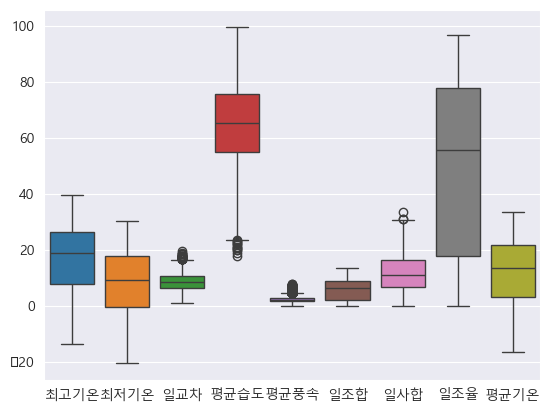

In [153]:
sns.boxplot(train.drop('강수량', axis = 1 ));

<Axes: ylabel='강수량'>

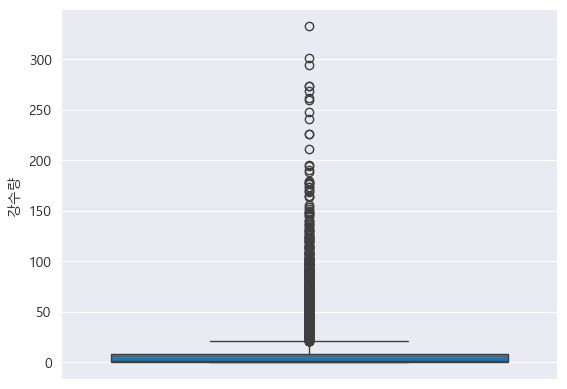

In [48]:
sns.boxplot(train['강수량'])

In [51]:
train.shape

(23011, 11)

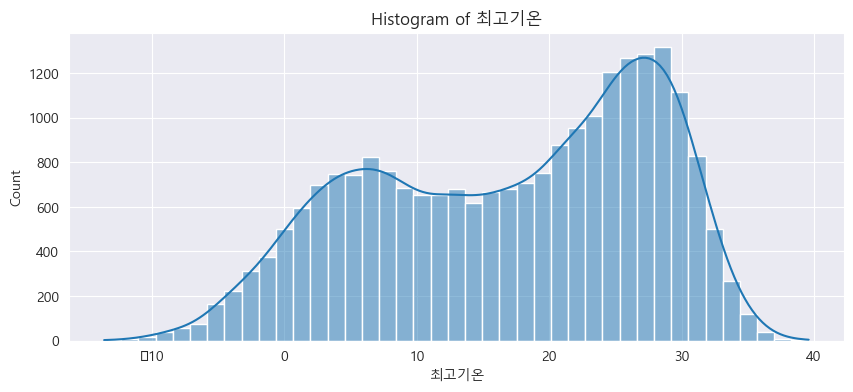

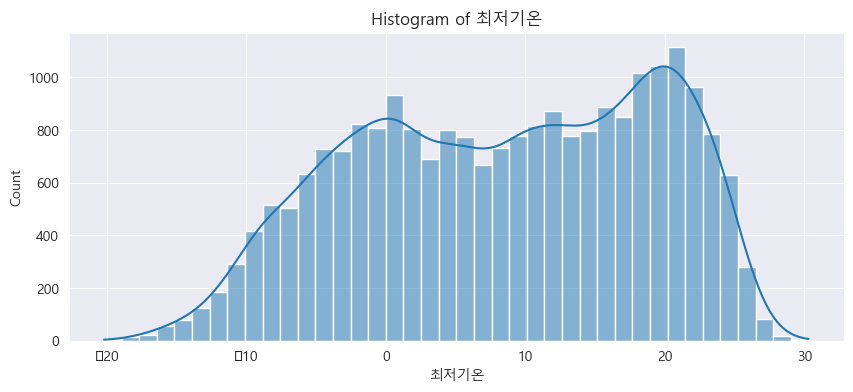

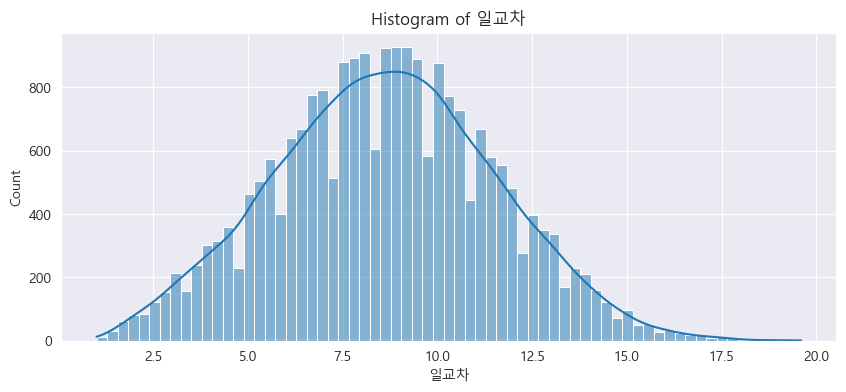

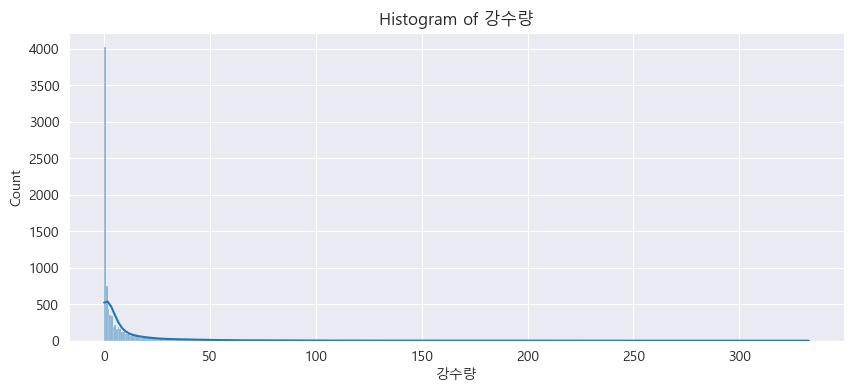

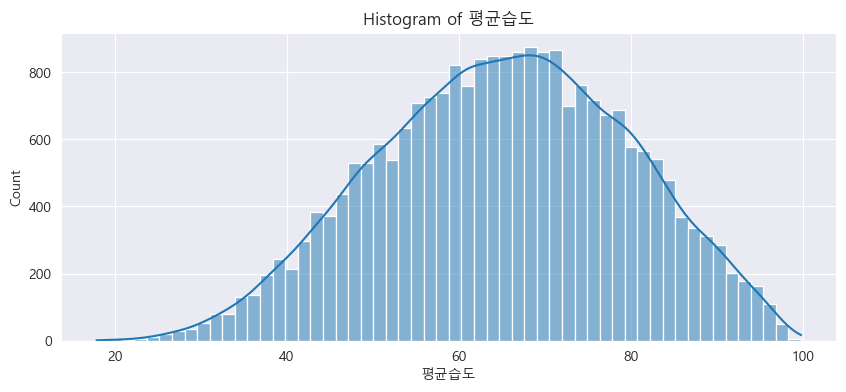

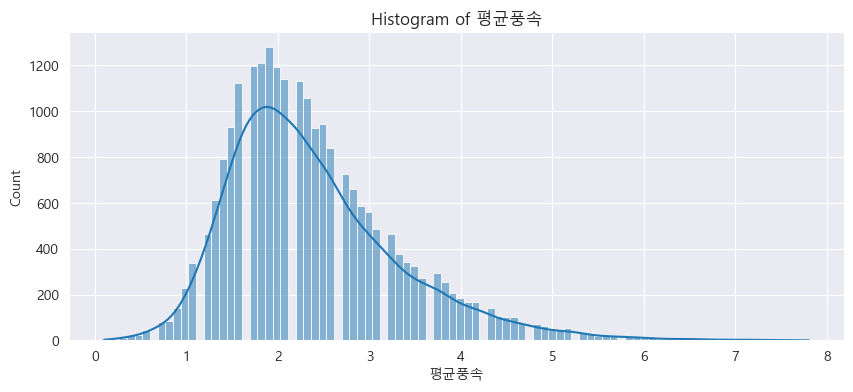

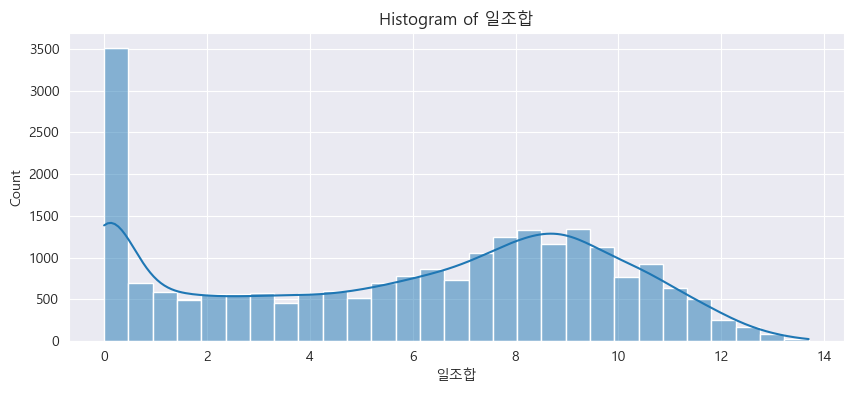

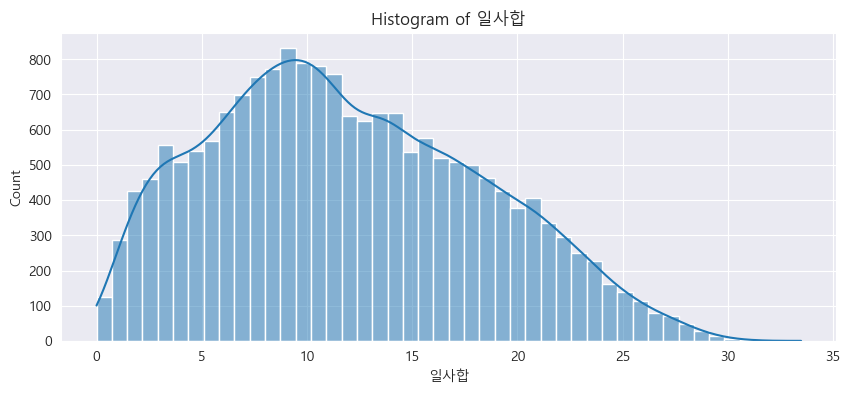

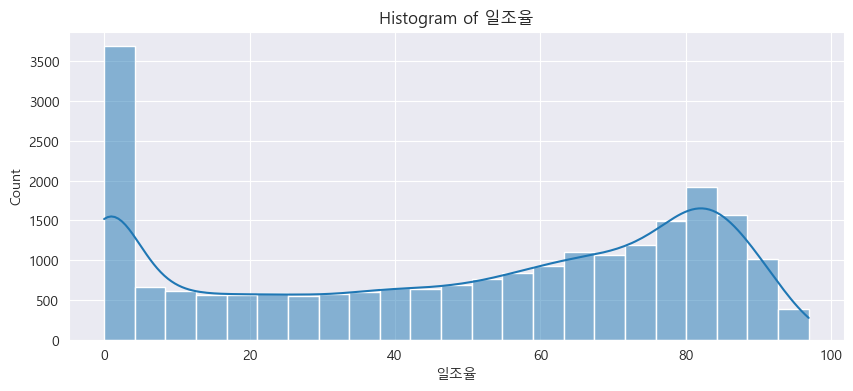

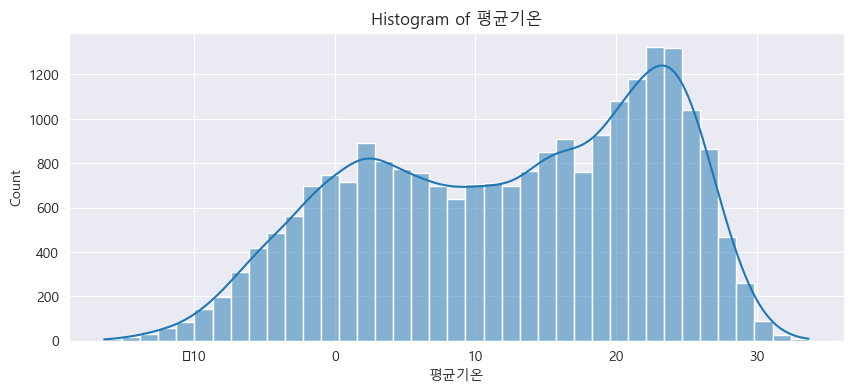

In [93]:
for column in train.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(train[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.show()

In [94]:
train.columns

Index(['일시', '최고기온', '최저기온', '일교차', '강수량', '평균습도', '평균풍속', '일조합', '일사합', '일조율',
       '평균기온'],
      dtype='object')

In [97]:
train.columns

Index(['일시', '최고기온', '최저기온', '일교차', '강수량', '평균습도', '평균풍속', '일조합', '일사합', '일조율',
       '평균기온'],
      dtype='object')

In [113]:
train['년'] = train['일시'].apply(lambda x : x.split('-'))

0        [1960, 01, 01]
1        [1960, 01, 02]
2        [1960, 01, 03]
3        [1960, 01, 04]
4        [1960, 01, 05]
              ...      
23006    [2022, 12, 27]
23007    [2022, 12, 28]
23008    [2022, 12, 29]
23009    [2022, 12, 30]
23010    [2022, 12, 31]
Name: 일시, Length: 23011, dtype: object

In [133]:
train['년'] = train['일시'].apply(lambda x : x.split('-')).apply(lambda x: x[0]).astype('int64')
train['월'] = train['일시'].apply(lambda x : x.split('-')).apply(lambda x: x[1]).astype('int64')
train['일'] = train['일시'].apply(lambda x : x.split('-')).apply(lambda x: x[2]).astype('int64')

In [130]:
train

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온,년,월,일
0,1960-01-01,2.2,-5.2,7.4,NaN,68.3,1.7,6.7,NaN,NaN,-1.6,1960,01,01
1,1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,NaN,NaN,-1.9,1960,01,02
2,1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,NaN,NaN,4.0,1960,01,03
3,1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,NaN,NaN,7.5,1960,01,04
4,1960-01-05,1.3,-8.2,9.5,NaN,44.0,5.1,8.2,NaN,NaN,-4.6,1960,01,05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23006,2022-12-27,3.3,-7.3,10.6,NaN,69.8,1.8,8.8,10.25,91.7,-2.6,2022,12,27
23007,2022-12-28,0.1,-6.0,6.1,0.1,58.1,2.5,8.7,10.86,90.6,-3.3,2022,12,28
23008,2022-12-29,2.1,-7.8,9.9,0.0,56.3,1.7,9.0,10.88,93.8,-2.9,2022,12,29
23009,2022-12-30,2.3,-4.4,6.7,0.0,65.6,1.9,7.9,10.84,82.3,-1.8,2022,12,30


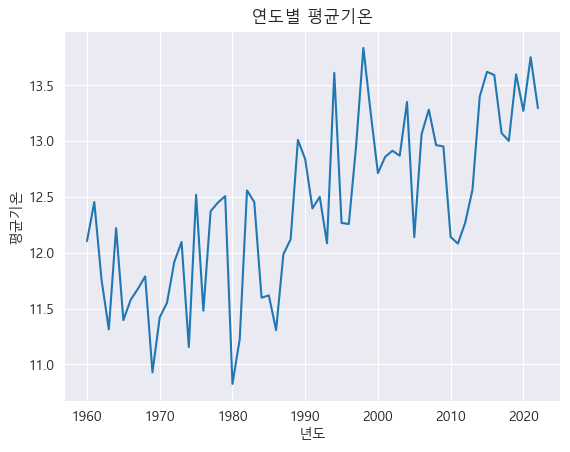

In [143]:
sns.lineplot(train.groupby(['년'])['평균기온'].mean())
# 그래프에 타이틀을 추가
plt.title('연도별 평균기온')

# x축 라벨을 설정
plt.xlabel('년도')

# y축 라벨을 설정
plt.ylabel('평균기온')

# 그래프를 보여줌
plt.show()

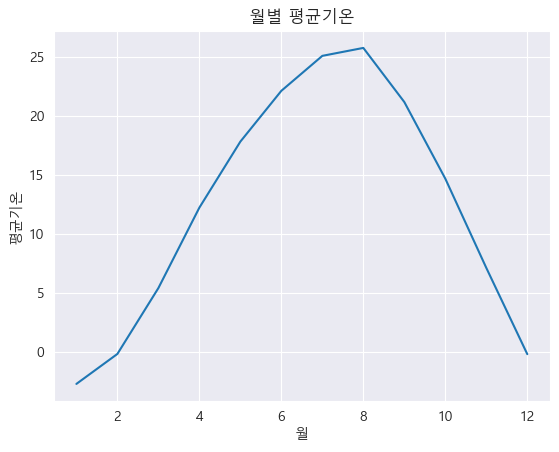

In [144]:
sns.lineplot(train.groupby(['월'])['평균기온'].mean())
# 그래프에 타이틀을 추가
plt.title('월별 평균기온')

# x축 라벨을 설정
plt.xlabel('월')

# y축 라벨을 설정
plt.ylabel('평균기온')

# 그래프를 보여줌
plt.show()